# Steps
1. Get stats about missing data points
2. Clean missing data points
3. Encode and binarize the labels
4. Split the test dataset between validation and test
5. Get the balance stats for each split
6. Run SMOTE
7. Run SPLIT -> depth = 2, max_depth = 5, lambda = 0.005, 0.006, 0.007, 0.008, 0.009, 0.01
8. Run XGBoost to select features -> baseline iteration, then cumulative gain = 80%, 90%, 95% , 97.5%, 99%
9. Run SPLIT with the selected features

## 1 and 2 - Get stats about missing data points, clean missing data points

In [30]:
import pandas as pd
import dimex as dx

RANDOM_SEED = 42

train_filename = 'airline-passenger-satisfaction/train.csv'
test_filename = 'airline-passenger-satisfaction/test.csv'

train_dataset = pd.read_csv(train_filename, index_col=0)
test_dataset = pd.read_csv(test_filename, index_col=0)

train_clean, train_missing_stats, train_clean_filename = dx.clean_missing(train_filename)
test_clean, test_missing_stats, test_clean_filename = dx.clean_missing(test_filename)

train_missing_stats = list(train_missing_stats.items())
test_missing_stats = list(test_missing_stats.items())

missing_tbl = []
missing_tbl.extend([{
    "dataset": "train",
    "size": len(train_dataset),
    train_missing_stats[0][0]: train_missing_stats[0][1],
    train_missing_stats[1][0]: format(train_missing_stats[1][1],".2%"),
}, {
    "dataset": "train",
    "size": len(test_dataset),
    test_missing_stats[0][0]: test_missing_stats[0][1],
    test_missing_stats[1][0]: format(test_missing_stats[1][1],".2%"),
},])

display(pd.DataFrame(missing_tbl))

Clean dataset saved to /mnt/c/Users/Lucas/Documents/Externship/SPLIT-ICML/airline-passenger-satisfaction/train_clean.csv
Clean dataset saved to /mnt/c/Users/Lucas/Documents/Externship/SPLIT-ICML/airline-passenger-satisfaction/test_clean.csv


,dataset,size,missing data points,% missing data points
0,train,103904,310,0.30%
1,train,25976,83,0.32%


## 3, 4, and 5 - Encode the features, binarize the labels, split the dataset, get the balance stats for each split

In [31]:
train_encoded, train_encoded_filename = dx.binarize_encode(train_clean_filename, "satisfied", "neutral or dissatisfied")
test_encoded, test_encoded_filename = dx.binarize_encode(test_clean_filename, "satisfied", "neutral or dissatisfied")

x_val, x_test, y_val, y_test = dx.split_dataset(test_encoded, test_size=2/3, random_state=RANDOM_SEED)

labels = train_encoded.columns[-1]
train_balance = dx.balance_stats(train_encoded[labels])
val_balance = dx.balance_stats(y_val)
test_balance = dx.balance_stats(y_test)

balance_stats = []
balance_stats.extend([{"dataset": "train",
                       "1": format(train_balance["1"], ".2%"),
                       "0": format(train_balance["0"], ".2%"),},
                      {"dataset": "validation",
                       "1": format(val_balance["1"], ".2%"),
                       "0": format(val_balance["0"], ".2%"),},
                      {"dataset": "test",
                       "1": format(test_balance["1"], ".2%"),
                       "0": format(test_balance["0"], ".2%"),}])

display(pd.DataFrame(balance_stats))

Encoded dataset saved to /mnt/c/Users/Lucas/Documents/Externship/SPLIT-ICML/airline-passenger-satisfaction/train_clean_encoded.csv
Encoded dataset saved to /mnt/c/Users/Lucas/Documents/Externship/SPLIT-ICML/airline-passenger-satisfaction/test_clean_encoded.csv


,dataset,1,0
0,train,43.34%,56.66%
1,validation,43.89%,56.11%
2,test,43.89%,56.11%


## 6 - Balance with SMOTE

In [32]:
x_train, y_train = train_encoded.drop(columns=[labels]), train_encoded[labels]
x_train_balanced, y_train_balanced = dx.smote(x_train, y_train, train_encoded_filename, random_state=RANDOM_SEED)

Balanced dataset saved to /mnt/c/Users/Lucas/Documents/Externship/SPLIT-ICML/airline-passenger-satisfaction/train_clean_encoded_balanced.csv


## 7 - Run SPLIT -> Depth = 2, max depth = 5, lambda = 0.005-0.01

In [33]:
# Iteration 0 -> Lambda = 0.005
model_0, tree_0, model_data_0 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.005)
train_prediction_0 = dx.prediction_split(model_0, x_train_balanced, y_train_balanced)
val_prediction_0 = dx.prediction_split(model_0, x_val, y_val)

# Iteration 1 -> Lambda = 0.006
model_1, tree_1, model_data_1 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.006)
train_prediction_1 = dx.prediction_split(model_1, x_train_balanced, y_train_balanced)
val_prediction_1 = dx.prediction_split(model_1, x_val, y_val)

# Iteration 2 -> Lambda = 0.007
model_2, tree_2, model_data_2 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.007)
train_prediction_2 = dx.prediction_split(model_2, x_train_balanced, y_train_balanced)
val_prediction_2 = dx.prediction_split(model_2, x_val, y_val)

# Iteration 3 -> Lambda = 0.008
model_3, tree_3, model_data_3 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.008)
train_prediction_3 = dx.prediction_split(model_3, x_train_balanced, y_train_balanced)
val_prediction_3 = dx.prediction_split(model_3, x_val, y_val)

# Iteration 4 -> Lambda = 0.009
model_4, tree_4, model_data_4 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.009)
train_prediction_4 = dx.prediction_split(model_4, x_train_balanced, y_train_balanced)
val_prediction_4 = dx.prediction_split(model_4, x_val, y_val)

# Iteration 5 -> Lambda = 0.01
model_5, tree_5, model_data_5 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.01)
train_prediction_5 = dx.prediction_split(model_5, x_train_balanced, y_train_balanced)
val_prediction_5 = dx.prediction_split(model_5, x_val, y_val)

models_data = [model_data_0, model_data_1, model_data_2, model_data_3, model_data_4, model_data_5]
train_predictions = [train_prediction_0, train_prediction_1, train_prediction_2, train_prediction_3, train_prediction_4, train_prediction_5]
val_predictions = [val_prediction_0, val_prediction_1, val_prediction_2, val_prediction_3, val_prediction_4, val_prediction_5]

split_results = []

for i in range(6):
    split_results.extend([{"lambda": models_data[i]["lambda"],
                           "leaves": models_data[i]["leaves"],
                           "training runtime (s)": format(models_data[i]["runtime"], ".2f"),
                           "training accuracy": format(train_predictions[i][1], ".2%"),
                           "validation accuracy": format(val_predictions[i][1], ".2%"),}])

display(pd.DataFrame(split_results))

,lambda,leaves,training runtime (s),training accuracy,validation accuracy
0,0.005,6,7.25,88.12%,88.92%
1,0.006,6,5.51,88.12%,88.92%
2,0.007,6,5.53,88.12%,88.92%
3,0.008,5,5.43,87.27%,88.46%
4,0.009,5,5.38,87.27%,88.46%
5,0.010,5,5.31,87.27%,88.46%


In [34]:
print("lambda",models_data[0]["lambda"], "tree:", tree_0, "\n")
print("lambda",models_data[1]["lambda"], "tree:", tree_1, "\n")
print("lambda",models_data[2]["lambda"], "tree:", tree_2)

lambda 0.005 tree: { feature: 0 [ left child: { prediction: 1, loss: 0.002058142563328147 }, right child: { feature: 8 [ left child: { feature: 1 [ left child: { feature: 3 [ left child: { prediction: 0, loss: 0.03891390189528465 }, right child: { prediction: 1, loss: 0.02518787421286106 }] }, right child: { prediction: 1, loss: 0.037398576736450195 }] }, right child: { feature: 2 [ left child: { prediction: 0, loss: 0.02133789099752903 }, right child: { prediction: 1, loss: 0.0 }] }] }] } 

lambda 0.006 tree: { feature: 0 [ left child: { prediction: 1, loss: 0.002058142563328147 }, right child: { feature: 8 [ left child: { feature: 1 [ left child: { feature: 3 [ left child: { prediction: 0, loss: 0.03891390189528465 }, right child: { prediction: 1, loss: 0.02518787421286106 }] }, right child: { prediction: 1, loss: 0.037398576736450195 }] }, right child: { feature: 2 [ left child: { prediction: 0, loss: 0.02133789099752903 }, right child: { prediction: 1, loss: 0.0 }] }] }] } 

lambda

Despite the different lambdas, the 3 trees are identical. Same number of leaves, same loss, same accuracy. I'm picking lambda = 0.007 because it keeps accuracy and tree size the same while giving the most regularization cushion against small shifts in data and pipeline or overfitting.

## 8 - Run XGBoost -> baseline iteration, cumulative gain = 80%-99%

In [35]:
# baseline
xgb_baseline, size_baseline, runtime_baseline = dx.train_xgb(x_train_balanced, y_train_balanced, random_state=RANDOM_SEED)
y_train_pred_baseline, acc_baseline = dx.prediction_xgb(xgb_baseline, x_train_balanced, y_train_balanced)
y_val_pred_baseline, acc_val_baseline = dx.prediction_xgb(xgb_baseline, x_val, y_val)

gain_sorted, total_gain = dx.sort_by_gain(xgb_baseline)

# cumulative gain = 80%
xgb_0, size_0, runtime_0, features_0 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .8, random_state=RANDOM_SEED)
y_train_pred_0, acc_0 = dx.prediction_xgb(xgb_0, x_train_balanced[features_0], y_train_balanced)
y_val_pred_0, acc_val_0 = dx.prediction_xgb(xgb_0, x_val[features_0], y_val)

# cumulative gain = 90%
xgb_1, size_1, runtime_1, features_1 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .9, random_state=RANDOM_SEED)
y_train_pred_1, acc_1 = dx.prediction_xgb(xgb_1, x_train_balanced[features_1], y_train_balanced)
y_val_pred_1, acc_val_1 = dx.prediction_xgb(xgb_1, x_val[features_1], y_val)

# cumulative gain = 95%
xgb_2, size_2, runtime_2, features_2 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .95, random_state=RANDOM_SEED)
y_train_pred_2, acc_2 = dx.prediction_xgb(xgb_2, x_train_balanced[features_2], y_train_balanced)
y_val_pred_2, acc_val_2 = dx.prediction_xgb(xgb_2, x_val[features_2], y_val)

# cumulative gain = 97.5%
xgb_3, size_3, runtime_3, features_3 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .975, random_state=RANDOM_SEED)
y_train_pred_3, acc_3 = dx.prediction_xgb(xgb_3, x_train_balanced[features_3], y_train_balanced)
y_val_pred_3, acc_val_3 = dx.prediction_xgb(xgb_3, x_val[features_3], y_val)

# cumulative gain = 99%
xgb_4, size_4, runtime_4, features_4 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .99, random_state=RANDOM_SEED)
y_train_pred_4, acc_4 = dx.prediction_xgb(xgb_4, x_train_balanced[features_4], y_train_balanced)
y_val_pred_4, acc_val_4 = dx.prediction_xgb(xgb_4, x_val[features_4], y_val)

xgb_iterations = ["baseline", "cumulative gain = 80%", "cumulative gain = 90%",
                  "cumulative gain = 95%", "cumulative gain = 97.5%",  "cumulative gain = 99%"]
xgb_train_acc = [acc_baseline, acc_0, acc_1, acc_2, acc_3, acc_4]
xgb_val_acc = [acc_val_baseline, acc_val_0, acc_val_1, acc_val_2, acc_val_3, acc_val_4]

xgb_results = []
for i in range(6):
    xgb_results.extend([{"iteration": xgb_iterations[i],
                         "training accuracy": format(xgb_train_acc[i],".2%"),
                         "validation accuracy": format(xgb_val_acc[i],".2%"),}])

display(pd.DataFrame(xgb_results))

,iteration,training accuracy,validation accuracy
0,baseline,92.41%,93.52%
1,cumulative gain = 80%,91.78%,92.82%
2,cumulative gain = 90%,92.18%,93.26%
3,cumulative gain = 95%,92.39%,93.45%
4,cumulative gain = 97.5%,92.31%,93.42%
5,cumulative gain = 99%,92.45%,93.44%


Both the baseline and the cumulative gain = 99% scenarios yielded the same accuracy. I'll pick the **99% cumulative gain**. Why? It's a simpler model, even if slightly.

In [36]:
print(runtime_baseline)

0.4060672020132188


**Features selected**

In [37]:
print(features_4)
print(len(features_4))

['Online_boarding', 'Type_of_Travel_Personal Travel', 'Class_Eco', 'Inflight_wifi_service', 'On_board_service', 'Customer_Type_disloyal Customer', 'Inflight_entertainment', 'Checkin_service', 'Leg_room_service', 'Flight_Distance', 'Departure_Arrival_time_convenient', 'Cleanliness', 'Baggage_handling', 'Seat_comfort', 'Gate_location', 'Arrival_Delay_in_Minutes', 'Inflight_service', 'Age', 'Gender_Male']
19


## 9 - Run SPLIT (lambda = 0.007) with the selected features

In [38]:
model_6, tree_6, model_data_6 = dx.train_split(x_train_balanced[features_4], y_train_balanced, 2, 5, 0.007)
train_prediction_6 = dx.prediction_split(model_6, x_train_balanced[features_4], y_train_balanced)
val_prediction_6 = dx.prediction_split(model_6, x_val[features_4], y_val)
test_prediction_6 = dx.prediction_split(model_6, x_test[features_4], y_test)

y_test_pred_4, acc_pred_4 = dx.prediction_xgb(xgb_4, x_test[features_4], y_test)

split_xgb_results = []
split_xgb_results.extend([{"model": "XGBoost",
                           "size": str(size_4["trees"]) + " trees, " + str(size_4["leaves"]) + " leaves",
                           "training runtime (s)": format(runtime_4, ".2f"),
                           "training accuracy": format(acc_4, ".2%"),
                           "validation accuracy": format(acc_val_4, ".2%"),
                           "testing accuracy": format(acc_pred_4, ".2%"),},
                          {"model": "SPLIT",
                           "size": str(model_data_6["leaves"]) + " leaves",
                           "training runtime (s)": format(model_data_6["runtime"], ".2f"),
                           "training accuracy": format(train_prediction_6[1], ".2%"),
                           "validation accuracy": format(val_prediction_6[1], ".2%"),
                           "testing accuracy": format(test_prediction_6[1], ".2%"),},])

display(pd.DataFrame(split_xgb_results))

,model,size,training runtime (s),training accuracy,validation accuracy,testing accuracy
0,XGBoost,"100 trees, 758 leaves",0.21,92.45%,93.44%,93.63%
1,SPLIT,6 leaves,5.13,88.12%,88.92%,88.87%


The accuracy didn't improve at all, nor did the leaves. What I'm doing now is applying a different set of parameters I found through tinkering with SPLIT in another notebook (no need to repeat the process here. It was the same trial-and-error process you saw on step 7, but also messing with depth and max depth.

## 9.1 - Run SPLIT (depth = 5, max depth = 6, lambda = 0.005) with selected features

In [39]:
split_xgb_results.pop()

model_7, tree_7, model_data_7 = dx.train_split(x_train_balanced[features_4], y_train_balanced, 5, 6, 0.005)
train_prediction_7 = dx.prediction_split(model_7, x_train_balanced[features_4], y_train_balanced)
val_prediction_7 = dx.prediction_split(model_7, x_val[features_4], y_val)
test_prediction_7 = dx.prediction_split(model_7, x_test[features_4], y_test)

split_xgb_results.extend([{"model": "SPLIT (depth=2, max depth=5, lambda=0.007)",
                           "size": str(model_data_6["leaves"]) + " leaves",
                           "training runtime (s)": format(model_data_6["runtime"], ".2f"),
                           "training accuracy": format(train_prediction_6[1], ".2%"),
                           "validation accuracy": format(val_prediction_6[1], ".2%"),
                           "testing accuracy": format(test_prediction_6[1], ".2%"),},
                          {"model": "SPLIT (depth=5, max depth=6, lambda=0.005)",
                           "size": str(model_data_7["leaves"]) + " leaves",
                           "training runtime (s)": format(model_data_7["runtime"], ".2f"),
                           "training accuracy": format(train_prediction_7[1], ".2%"),
                           "validation accuracy": format(val_prediction_7[1], ".2%"),
                           "testing accuracy": format(test_prediction_7[1], ".2%"),},])

display(pd.DataFrame(split_xgb_results))

,model,size,training runtime (s),training accuracy,validation accuracy,testing accuracy
0,XGBoost,"100 trees, 758 leaves",0.21,92.45%,93.44%,93.63%
1,"SPLIT (depth=2, max depth=5, lambda=0.007)",6 leaves,5.13,88.12%,88.92%,88.87%
2,"SPLIT (depth=5, max depth=6, lambda=0.005)",8 leaves,19.20,90.36%,91.79%,91.97%


As expected, accuracy went up sharply here, and the gap narrowed significantly, especially in validation and testing. For this random seed, SPLIT with depth 5, max depth 6 and lambda 0.005 is the more accurate option. Below, its tree.

In [40]:
print(tree_7)

{ feature: 4 [ left child: { prediction: 1, loss: 0.002058142563328147 }, right child: { feature: 2 [ left child: { feature: 5 [ left child: { feature: 8 [ left child: { feature: 1 [ left child: { prediction: 0, loss: 0.15022143721580505 }, right child: { prediction: 1, loss: 0.0033116545528173447 }] }, right child: { feature: 7 [ left child: { prediction: 1, loss: 0.018142402172088623 }, right child: { prediction: 0, loss: 0.012056900188326836 }] }] }, right child: { prediction: 1, loss: 0.14474715292453766 }] }, right child: { feature: 6 [ left child: { prediction: 0, loss: 0.07740987092256546 }, right child: { prediction: 1, loss: 0 }] }] }] }


Below, the tree for Model[1] (SPLIT with depth 2, max depth 5, and lambda 0.007), which I'll be using for our presentation.

In [41]:
print(tree_6)

{ feature: 4 [ left child: { prediction: 1, loss: 0.002058142563328147 }, right child: { feature: 2 [ left child: { feature: 0 [ left child: { feature: 5 [ left child: { prediction: 0, loss: 0.03891390189528465 }, right child: { prediction: 1, loss: 0.008880509994924068 }] }, right child: { prediction: 1, loss: 0.05370594188570976 }] }, right child: { feature: 6 [ left child: { prediction: 0, loss: 0.02133789099752903 }, right child: { prediction: 1, loss: 0.0 }] }] }] }


**Confusion matrix for Model[0] (XGBoost)**

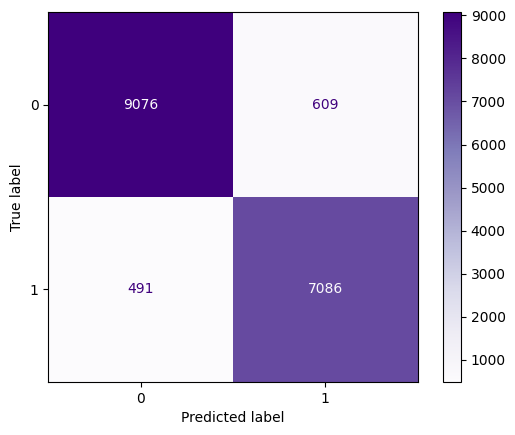

In [42]:
xbg_cm = dx.cm(y_test, y_test_pred_4, cmap="Purples")

**Confusion matrix for Model[1] ((SPLIT with depth 2, max depth 5, and lambda 0.007))**

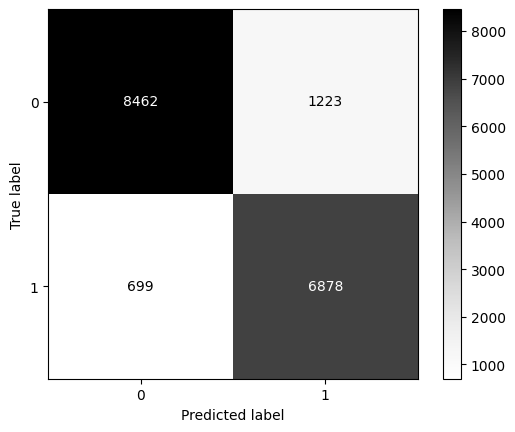

In [43]:
split_cm = dx.cm(y_test, test_prediction_6[0], cmap="Greys")

**Model[1] features list**

In [44]:
display(pd.DataFrame(dx.binarized_features(model_6))["name"])

0                     Online_boarding <= 3.5
1                     Online_boarding <= 4.5
2      Type_of_Travel_Personal Travel <= 0.5
3                           Class_Eco <= 0.5
4               Inflight_wifi_service <= 0.5
5               Inflight_wifi_service <= 3.5
6               Inflight_wifi_service <= 4.5
7     Customer_Type_disloyal Customer <= 0.5
8              Inflight_entertainment <= 3.5
9                    Leg_room_service <= 3.5
10                   On_board_service <= 3.5
Name: name, dtype: object